In [93]:
# Run with 'solar': conda
%reset -f
from tsai.all import *

In [94]:
num_weeks = 10
num_steps_per_week = 7
num_steps_per_day = 24
num_points = num_weeks * num_steps_per_week * num_steps_per_day

In [95]:
data = np.zeros((num_points, 4))
X_time = np.linspace(1, num_points, num_points)

Create `numpy` array with four columns.

In [96]:
def create_sample_data(with_unique=False):
    if with_unique:
        data[0::2,0] = 1
        data[1::2,0] = 2
    else:
        data[:,0] = 1
    data[:,1] = 2*np.sin(2*np.pi*X_time/num_steps_per_week/num_steps_per_day)
    data[:,2] = 2*np.sin(2*np.pi*X_time/num_steps_per_week/num_steps_per_day + 2)
    data[:,3] = data[:,1] + data[:,2] + np.random.randint(-10,10,(num_points))/10
    return data

Create `dataframe` with four columns.

In [97]:
data = create_sample_data()
tmp = pd.DataFrame(data, columns=['unique_id', 'var1', 'var2', 'target'])
tmp.head()

,unique_id,var1,var2,target
0,1.0,0.074782,1.786203,2.160985
1,1.0,0.149460,1.751312,1.600772
2,1.0,0.223929,1.713973,2.637902
3,1.0,0.298085,1.674236,1.872320
4,1.0,0.371823,1.632157,1.603980


In [98]:
#np.random.seed(42)
#chc = np.random.choice(len(tmp), len(tmp), False)
#print(chc)
#df = tmp.loc[chc].reset_index()


In [99]:
df = tmp.reset_index()
df.rename(columns={'index': 'time'}, inplace=True)
df = df.sort_values('time')
df.head()

,time,unique_id,var1,var2,target
0,0,1.0,0.074782,1.786203,2.160985
1,1,1.0,0.149460,1.751312,1.600772
2,2,1.0,0.223929,1.713973,2.637902
3,3,1.0,0.298085,1.674236,1.872320
4,4,1.0,0.371823,1.632157,1.603980


`SlidingWindow` parameters.

In [100]:
add_padding_feature = False #1 Add an additional feature indicating whether each timestep is padded (1) or not (0).
ascending = True #2 Used in sorting.
check_leakage = True #3 Checks if there's leakage in the output between X and y
copy_=True #4 Copy the original object to avoid changes in it.
get_x = ['var1', 'var2'] #5 Indices of columns that contain the independent variable (xs). If None, all data will be used as x.
get_y = ['target'] #6 Indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created (unlabeled data).
horizon = num_steps_per_week*num_steps_per_day #7 Number of future datapoints to predict (y). If get_y == [] horizon will be set to 0.
output_processor = None #8 (Optional) Function to process the final output (X (and y if available)). This is useful when some values need to be removed.
padding = 'pre' #9 (Optional) Pad either before or after each sequence. Defaults: 'pre'. If pad_remainder == False, it indicates the starting point to create the sequence ('pre' from the end, and 'post' from the beginning)
padding_value = np.nan #10 Float that will be used for padding. Default: np.nan.
pad_remainder = False #11 Allows to pad remainder subsequences when the sliding window is applied and get_y == [] (unlabeled data).
return_key = False #12 When True, the key corresponsing to unique_id_cols for each sample is returned
seq_first = True #13 True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len).
sort_by = ['time'] #14 Column/s used for sorting the array in ascending order.
start = 0 #15 Determines the step where the first window is applied. Default: 0. Previous steps will be discarded. 
stride = 1 #16 Number of datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap).
unique_id_cols = []#['unique_id'] #17 pd.DataFrame columns that will be used to identify a time series for each entity.
verbose = True #18 Controls verbosity. True or 1 displays progress bar. 2 or more show records that cannot be created due to its length.
window_len = num_steps_per_week*num_steps_per_day #19 Length of lookback.
y_func = None #20 Optional function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!.

Apply `SlidingWindowPanel` on `DataFrame`.

In [101]:
X, y = SlidingWindowPanel(
                          add_padding_feature=add_padding_feature,
                          ascending=ascending,
                          check_leakage=check_leakage,
                          copy=copy_,
                          get_x=get_x,
                          get_y=get_y,
                          horizon=horizon,
                          #output_processor=output_processor,
                          padding=padding,
                          padding_value=padding_value,
                          pad_remainder=pad_remainder,
                          return_key=return_key,
                          seq_first=seq_first,
                          sort_by=sort_by,
                          start=start,
                          stride=stride,
                          unique_id_cols=unique_id_cols,
                          verbose=verbose,
                          window_len=window_len,
                          y_func=y_func,
                          )(df)

processing data...


...data processed
concatenating X...
...X concatenated
concatenating y...
...y concatenated


Faster way to apply `SlidingWindow` (on `ndarray`, `Tensor` or `DataFrame`)

In [102]:
output = [df.groupby(['unique_id']).apply(lambda x: SlidingWindow(
    add_padding_feature=add_padding_feature,
    ascending=ascending,
    check_leakage=check_leakage,
    copy=copy_, # it's important to set copy to True when used in this way!!!
    get_x=get_x,
    get_y=get_y,
    horizon=horizon,
    #output_processor=output_processor,
    padding=padding,
    padding_value=padding_value,
    pad_remainder=pad_remainder,
    #return_key=return_key, {unexpected keyword}
    seq_first=seq_first,
    sort_by=sort_by,
    start=start,
    stride=stride,
    #unique_id_cols=unique_id_cols, {unexpected keyword}
    #verbose=verbose, {unexpected keyword}
    window_len=window_len,
    y_func=y_func,
)(x))][0].values

X2 = np.concatenate([oi[0] for oi in output])
y2 = np.concatenate([oi[1] for oi in output])

(?, len(get_x), window_len) (?, horizon)

In [103]:
print(type(X), type(y))
print(X.shape, y.shape)
print(type(X2), type(y2))
print(X2.shape, y2.shape)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(2259600, 2, 168) (2259600, 168)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1345, 2, 168) (1345, 168)


In [104]:
def plot_Xy(X, y):
    lim = 10
    half_lim = int(lim/2)
    num = X.shape[0]
    feat = X.shape[1]
    if num > lim:
        print(f"Zu viele Batches. Stelle nur die ersten und letzten {half_lim} dar.")
        num = lim
    fig, axs = subplots(1, num)
    for c,n in enumerate(range(half_lim)):
        for f in range(feat):
            axs[c].plot(X[n,f,:])#, 'tab:green')
        axs[c].plot(y[n])#, 'tab:red')
        axs[c].grid()
    for c,n in enumerate(range(int(X.shape[0]-half_lim-1), X.shape[0]-1)):
        for f in range(feat):
            axs[c + half_lim].plot(X[n,f,:])#, 'tab:green')
        axs[c + half_lim].plot(y[n])#, 'tab:red')
        axs[c + half_lim].grid()

Zu viele Batches. Stelle nur die ersten und letzten 5 dar.


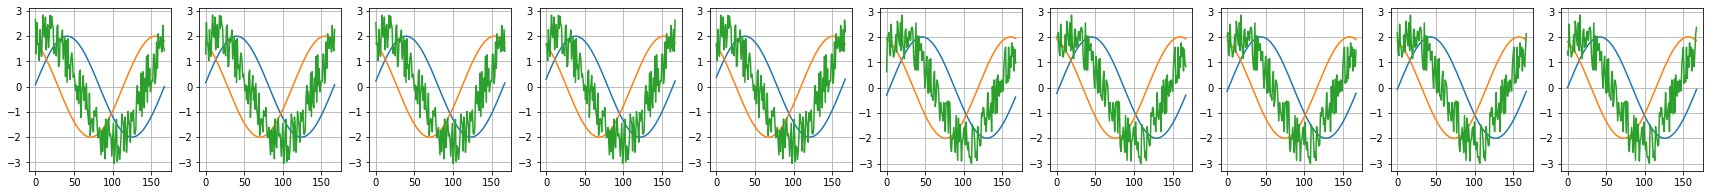

In [105]:
plot_Xy(X, y)

Zu viele Batches. Stelle nur die ersten und letzten 5 dar.


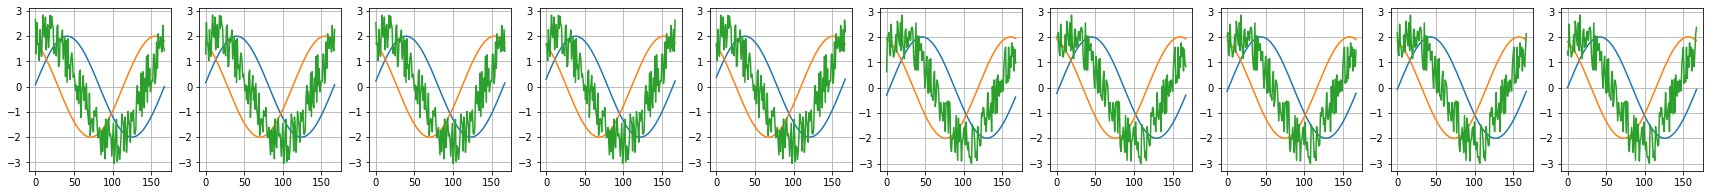

In [106]:
plot_Xy(X2, y2)

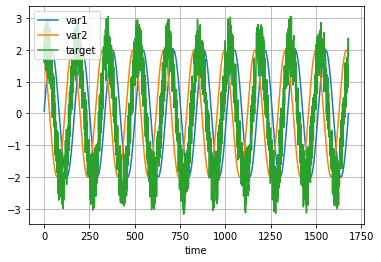

In [107]:
df.plot(x='time', y=['var1', 'var2', 'target'], grid=True);

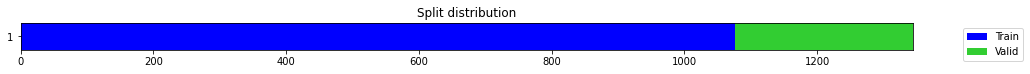

((#1076) [0,1,2,3,4,5,6,7,8,9...],
 (#269) [1076,1077,1078,1079,1080,1081,1082,1083,1084,1085...])

In [108]:
splits = get_splits(o=y2, n_splits=1, valid_size=.2, shuffle=False)
splits


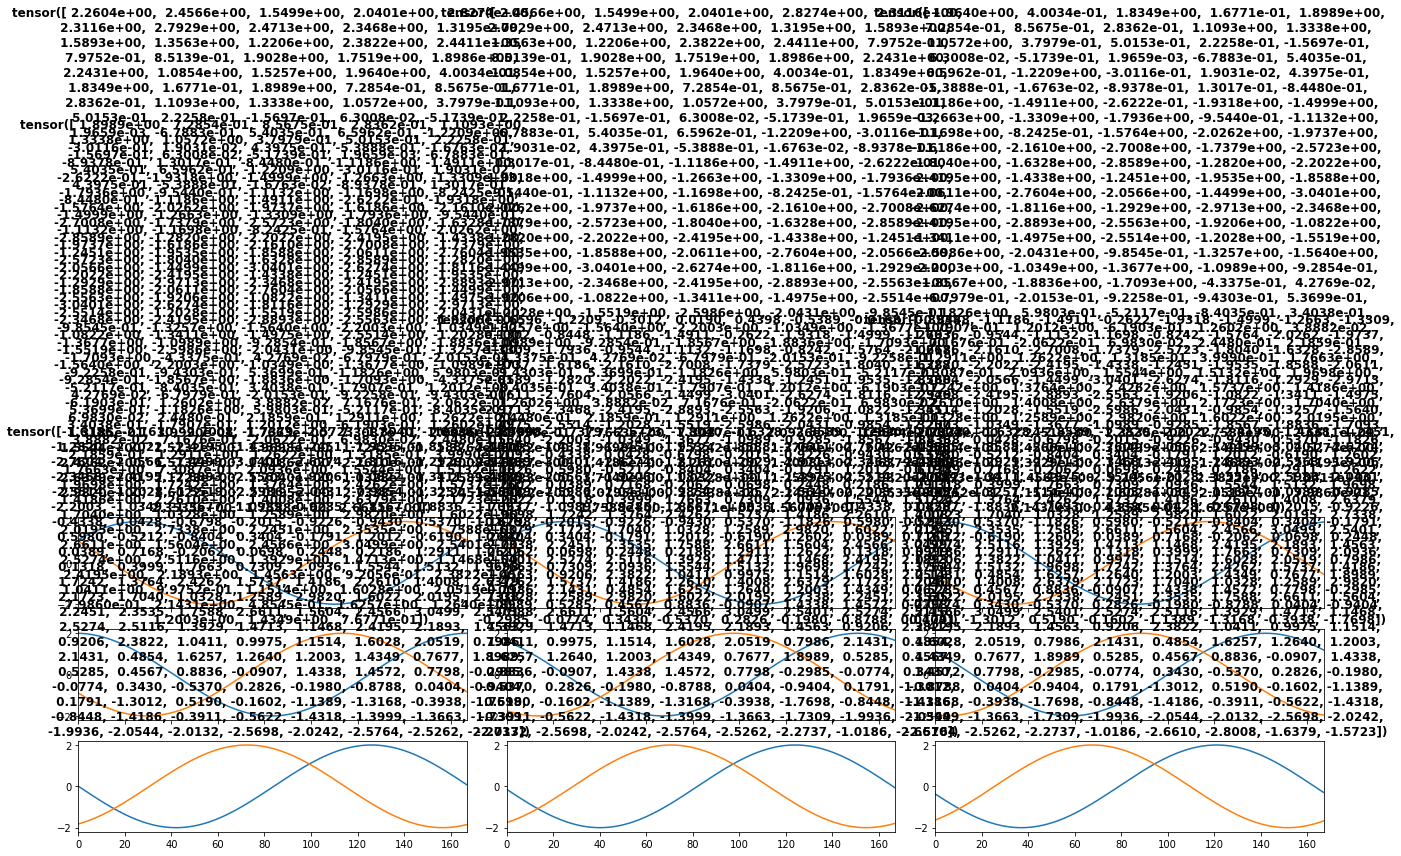

In [109]:
dls = get_ts_dls(X=X2, y=y2, splits=splits)
dls.show_batch()

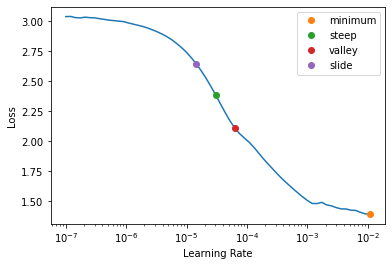

In [110]:
learn = ts_learner(dls, InceptionTimePlus, cbs=ShowGraph())
lrs = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

epoch,train_loss,valid_loss,time
0,2.552798,2.345559,00:21
1,2.053145,1.695134,00:21
2,1.567337,0.761503,00:21
3,1.162331,0.388847,00:21
4,0.902925,0.394960,00:21
5,0.735233,0.351907,00:21
6,0.619773,0.334478,00:21
7,0.538952,0.329512,00:21
8,0.482442,0.327456,00:21
9,0.442653,0.329554,00:21


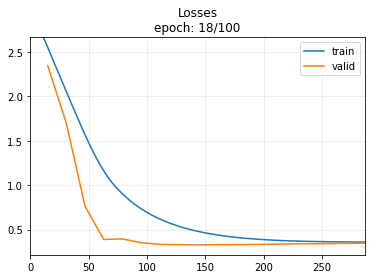

KeyboardInterrupt: 

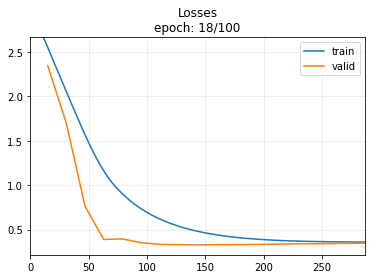

In [111]:
learn.fit_one_cycle(100, lr_max=lrs.valley)

In [ ]:
probas, _, preds = learn.get_X_preds(X[splits[1]])
probas.shape, preds.shape

(torch.Size([24, 24]), torch.Size([24, 24]))

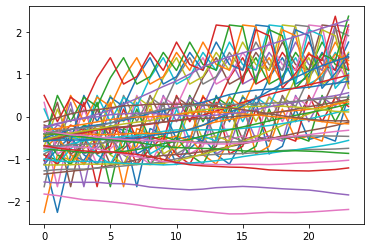

In [ ]:
plt.plot(y2[splits[1]])
plt.plot(preds)
plt.show()